Learns non-chaotic lorenz with $\rho(t)$ transitioning from 10 to 14.  

In [ ]:
# Import the necessary packages:
from torchdiffeq import odeint_adjoint as odeint
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn

from tqdm import tqdm
from ipywidgets import interact, IntSlider


#import Networkx as net
#import Plot3D as plot3d

#Neural ODE library
import Neural_ODEs_v1 as nodes
import DynamicalSystems as ds


#set random seed to 107
torch.manual_seed(107)
np.random.seed(107)

# Generating Data

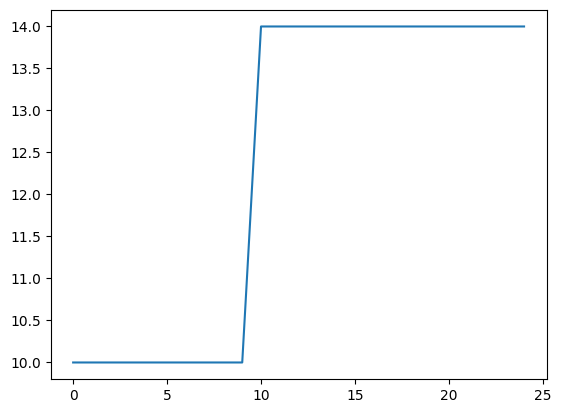

In [2]:
#r_vals = np.arange(14, 15, 1, dtype=np.float32)
r_vals = [10.0, 14.0]
def rho(t, r_vals = r_vals, step = 10):
    if t < step:
        return r_vals[0]
    elif t >= step:
        return r_vals[1]

plt.plot([rho(t) for t in range(0, 25)])

In [3]:
lorenz = ds.Lorenz(rho = rho)

#Generating data from Lorenz System with fixed parameters
dt = 0.05
initial_conditions = [[1.0, 1.0, 1.0], [-1.0, -1.0, 1.0]]
time_spans = [(0, 15)]
list = []

for t_span in time_spans:
    out = lorenz.solve(x0 = initial_conditions, t_span = t_span, dt = dt)
    list.append(np.expand_dims(out, axis=0))

data_full = np.concatenate(list, axis=0)
data_full.shape

(1, 300, 2, 3)

### Normalizing Data

In [4]:
norm = nodes.normalize_data(data_full.reshape(-1, 3))
data_norm = norm.normalize(data_full)

## Plotting 

In [5]:
data_norm.shape

(1, 300, 2, 3)

In [6]:
def plot_interact(index):
    #Normalised Plot
    fig = plt.figure(figsize=(6, 8))
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    #ax1.set_title('r = '+str(r_list[2*index]), fontsize=14)
    ax1.plot(xs=data_norm[:index, 0, 0], ys=data_norm[:index, 0, 1], zs=data_norm[:index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[:index, 1, 0], ys=data_norm[:index, 1, 1], zs=data_norm[:index, 1, 2], color = 'red', linewidth = 1)

    ax1.plot(xs=data_norm[:index, 0, 0], ys=data_norm[:index, 0, 1], zs=data_norm[:index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[:index, 1, 0], ys=data_norm[:index, 1, 1], zs=data_norm[:index, 1, 2], color = 'red', linewidth = 1)

    ax1.plot(xs=data_norm[:index, 0, 0], ys=data_norm[:index, 0, 1], zs=data_norm[:index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[:index, 1, 0], ys=data_norm[:index, 1, 1], zs=data_norm[:index, 1, 2], color = 'red', linewidth = 1)


    ax1.view_init(elev = 30, azim = 120)

    

In [7]:
data_norm[0, :, 0, 0].shape

(300,)

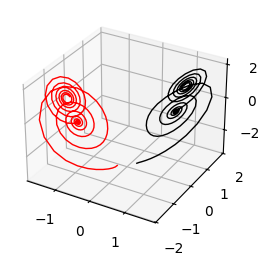

In [8]:

fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
#ax1.set_title('r = '+str(r_list[2*index]), fontsize=14)
ax1.plot(xs=data_norm[0, :, 0, 0], ys=data_norm[0, :, 0, 1], zs=data_norm[0, :, 0, 2], color = 'black', linewidth = 1 )
ax1.plot(xs=data_norm[0, :, 1, 0], ys=data_norm[0, :, 1, 1], zs=data_norm[0, :, 1, 2], color = 'red', linewidth = 1)   



# Training Neural ODE

In [9]:
model = nodes.Piecewise_Auto_NODE(spatial_dim=3, depth=5, width = 30, time_range=[0, 15], num_breakpoints=1, activation_func=nn.Tanh())

In [10]:
#Saving loss and setting optimiser 
loss_list = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


#Putting data into tensor 
#t_eval_tensor =  torch.tensor(np.arange(tstart, tfinal, dt))
training_data_tensor = torch.tensor(data_norm)

In [11]:
np.array([np.arange(time_spans[i][0], time_spans[i][1], dt) for i in range(len(time_spans))])

array([[ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
         0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
         0.9 ,  0.95,  1.  ,  1.05,  1.1 ,  1.15,  1.2 ,  1.25,  1.3 ,
         1.35,  1.4 ,  1.45,  1.5 ,  1.55,  1.6 ,  1.65,  1.7 ,  1.75,
         1.8 ,  1.85,  1.9 ,  1.95,  2.  ,  2.05,  2.1 ,  2.15,  2.2 ,
         2.25,  2.3 ,  2.35,  2.4 ,  2.45,  2.5 ,  2.55,  2.6 ,  2.65,
         2.7 ,  2.75,  2.8 ,  2.85,  2.9 ,  2.95,  3.  ,  3.05,  3.1 ,
         3.15,  3.2 ,  3.25,  3.3 ,  3.35,  3.4 ,  3.45,  3.5 ,  3.55,
         3.6 ,  3.65,  3.7 ,  3.75,  3.8 ,  3.85,  3.9 ,  3.95,  4.  ,
         4.05,  4.1 ,  4.15,  4.2 ,  4.25,  4.3 ,  4.35,  4.4 ,  4.45,
         4.5 ,  4.55,  4.6 ,  4.65,  4.7 ,  4.75,  4.8 ,  4.85,  4.9 ,
         4.95,  5.  ,  5.05,  5.1 ,  5.15,  5.2 ,  5.25,  5.3 ,  5.35,
         5.4 ,  5.45,  5.5 ,  5.55,  5.6 ,  5.65,  5.7 ,  5.75,  5.8 ,
         5.85,  5.9 ,  5.95,  6.  ,  6.05,  6.1 ,  6.15,  6.2 ,  6.25,
      

In [12]:
times = np.array([np.arange(time_spans[i][0], time_spans[i][1], dt) for i in range(len(time_spans))])
t_eval_tensor = torch.tensor(times)
t_eval_tensor.shape

torch.Size([1, 300])

## Single Loop 

In [91]:
training_data_tensor.shape

torch.Size([1, 300, 2, 3])

In [14]:

t_eval_tensor.shape[1]

300

In [15]:
#Single training loop
optimizer.zero_grad()

pred_x_list = []
for i in range(t_eval_tensor.shape[0]):

    pred_x_temp = odeint(model, training_data_tensor[i, 0, :, :].float(), t_eval_tensor[i, :].float(), method='rk4', options={'step_size': dt})
    pred_x_list.append(pred_x_temp)

pred_x = torch.stack(pred_x_list, dim=0)

loss_fn = nn.L1Loss()
train_loss = loss_fn(pred_x, training_data_tensor.float())

train_loss.backward()
optimizer.step()

print('Total Loss: ', train_loss)
print('Gradient of Breakpoints:', model.break_params.grad)
print('')


Total Loss:  tensor(2.0079, grad_fn=<MeanBackward0>)
Gradient of Breakpoints: tensor([0.0668])



In [16]:
optimizer.zero_grad()




pred_x = odeint(model, training_data_tensor[0, 0, :, :].float(), t_eval_tensor[0, :].float(), method='rk4', options={'step_size': dt})


loss_fn = nn.L1Loss()
train_loss = loss_fn(pred_x, training_data_tensor[0, :, :, :].float())

train_loss.backward()
optimizer.step()

print('Total Loss: ', train_loss)
print('Gradient of Breakpoints:', model.break_params.grad)
print('')


Total Loss:  tensor(1.5827, grad_fn=<MeanBackward0>)
Gradient of Breakpoints: tensor([0.0283])



## Main Training Loop

In [17]:
def batch(data: torch.tensor, t: torch.tensor, batch_length: int, num_batch: int): # data shape (traj, dim, time) #All traj same length 
    '''
    Generates batches of data for training. 

    Input shape should be (time, traj, dim).

    Modifed to allow for multiple time spans

    Parameters:
    -----------       
    data : torch.tensor
        The full dataset from which to sample batches. (num_time_spans, time, traj, dim)

    t : torch.tensor
        The corresponding time tensor. (num_time_spans, time)
    '''
    data_length = data.shape[1]
    if batch_length >= data_length:
        raise ValueError("Batch length must be less than the length of the data.")
    else:
    #num_traj = data.shape[0]
        #traj_indices = np.random.randint(0, num_traj, batch_size)
        ic_indices = np.random.randint(0, data_length - batch_length, num_batch)

        batch_list = []
        batch_time_list = []

        for i in range(0, num_batch):
            batch_list.append(data[:, ic_indices[i]:ic_indices[i]+batch_length, :, :].float())
            batch_time_list.append(t[:, ic_indices[i]:ic_indices[i]+batch_length].float().requires_grad_(True))
        
        #Each batch has shape (num_time_spans, batch_length, traj, dim) and each batch time has shape (num_time_spans, batch_length)

        return batch_list, batch_time_list

In [18]:
training_data_tensor.shape

torch.Size([1, 300, 2, 3])

In [81]:
batch_length = 20
num_batch = 15
num_epochs = 1000

for epoch in tqdm(range(num_epochs)):
    batch_list, batch_time_list = batch(training_data_tensor, t_eval_tensor, batch_length=batch_length, num_batch=num_batch)
    for i in range(0, num_batch):
        batch_i = batch_list[i]
        batch_time_i = batch_time_list[i]

        optimizer.zero_grad()

        #Predicting the trajectory
  
        pred_x_list = []
        for i in range(t_eval_tensor.shape[0]):
            pred_x_temp = odeint(model, batch_i[i, 0, :, :], batch_time_i[i, :], method='rk4', options={'step_size': dt})
            pred_x_list.append(pred_x_temp)

        pred_x = torch.stack(pred_x_list, dim=0)

        #Calculating loss
        loss = loss_fn(pred_x, batch_i.float()) 
        #loss_list.append(loss.item())

        #Backpropagation
        loss.backward()
        optimizer.step()

    if epoch%20==0:
            #Calculate training loss
            with torch.no_grad():
                temp_list = []
                pred_x_list = []
                for i in range(t_eval_tensor.shape[0]):

                    pred_x_temp = odeint(model, training_data_tensor[i, 0, :, :].float(), t_eval_tensor[i, :].float(), method='rk4', options={'step_size': dt})
                    pred_x_list.append(pred_x_temp)

                pred_x = torch.stack(pred_x_list, dim=0)
                
                train_loss = loss_fn(pred_x, training_data_tensor.float())
                loss_list.append(train_loss.item())


    if epoch % 20 == 0:
            print(f'Epoch {epoch}, Loss: {train_loss.item()}')
     
    
   

  0%|          | 1/1000 [00:05<1:37:51,  5.88s/it]

Epoch 0, Loss: 0.11444301903247833


  2%|▏         | 21/1000 [15:28<17:32:38, 64.51s/it] 

Epoch 20, Loss: 0.1706427037715912


  4%|▍         | 41/1000 [17:17<1:30:17,  5.65s/it] 

Epoch 40, Loss: 0.17045153677463531


  6%|▌         | 61/1000 [19:04<1:25:12,  5.44s/it]

Epoch 60, Loss: 0.26742735505104065


  8%|▊         | 81/1000 [20:51<1:24:16,  5.50s/it]

Epoch 80, Loss: 0.1569494903087616


 10%|█         | 101/1000 [22:36<1:21:05,  5.41s/it]

Epoch 100, Loss: 0.1539885401725769


 12%|█▏        | 121/1000 [24:22<1:19:54,  5.45s/it]

Epoch 120, Loss: 0.15037283301353455


 14%|█▍        | 141/1000 [26:08<1:18:46,  5.50s/it]

Epoch 140, Loss: 0.12738381326198578


 16%|█▌        | 161/1000 [27:53<1:15:37,  5.41s/it]

Epoch 160, Loss: 0.14340950548648834


 18%|█▊        | 181/1000 [29:39<1:13:21,  5.37s/it]

Epoch 180, Loss: 0.12218718975782394


 20%|██        | 201/1000 [31:24<1:10:41,  5.31s/it]

Epoch 200, Loss: 0.17133785784244537


 22%|██▏       | 221/1000 [33:10<1:11:47,  5.53s/it]

Epoch 220, Loss: 0.12869076430797577


 24%|██▍       | 241/1000 [34:56<1:10:02,  5.54s/it]

Epoch 240, Loss: 0.1514105498790741


 26%|██▌       | 261/1000 [36:42<1:06:57,  5.44s/it]

Epoch 260, Loss: 0.11916090548038483


 28%|██▊       | 281/1000 [38:33<1:06:40,  5.56s/it]

Epoch 280, Loss: 0.14577867090702057


 30%|███       | 301/1000 [40:17<1:04:15,  5.52s/it]

Epoch 300, Loss: 0.14173875749111176


 32%|███▏      | 321/1000 [42:04<1:03:04,  5.57s/it]

Epoch 320, Loss: 0.15662626922130585


 34%|███▍      | 341/1000 [43:50<1:00:29,  5.51s/it]

Epoch 340, Loss: 0.11521657556295395


 36%|███▌      | 361/1000 [45:37<57:26,  5.39s/it]  

Epoch 360, Loss: 0.1284918636083603


 38%|███▊      | 381/1000 [47:23<55:58,  5.43s/it]

Epoch 380, Loss: 0.1280040293931961


 40%|████      | 401/1000 [49:09<54:51,  5.49s/it]

Epoch 400, Loss: 0.1293574422597885


 42%|████▏     | 421/1000 [50:54<52:55,  5.48s/it]

Epoch 420, Loss: 0.11755937337875366


 44%|████▍     | 441/1000 [52:40<50:24,  5.41s/it]

Epoch 440, Loss: 0.1020607054233551


 46%|████▌     | 461/1000 [54:26<49:06,  5.47s/it]

Epoch 460, Loss: 0.12303727865219116


 48%|████▊     | 481/1000 [56:01<42:24,  4.90s/it]

Epoch 480, Loss: 0.15426231920719147


 50%|█████     | 501/1000 [57:34<39:46,  4.78s/it]

Epoch 500, Loss: 0.10022666305303574


 52%|█████▏    | 521/1000 [59:08<38:54,  4.87s/it]

Epoch 520, Loss: 0.23571862280368805


 54%|█████▍    | 541/1000 [1:00:43<37:22,  4.89s/it]

Epoch 540, Loss: 0.12944605946540833


 56%|█████▌    | 561/1000 [1:02:18<35:51,  4.90s/it]

Epoch 560, Loss: 0.1333579123020172


 58%|█████▊    | 581/1000 [1:03:52<33:36,  4.81s/it]

Epoch 580, Loss: 0.13109341263771057


 60%|██████    | 601/1000 [1:05:27<32:34,  4.90s/it]

Epoch 600, Loss: 0.1351887285709381


 62%|██████▏   | 621/1000 [1:07:02<30:30,  4.83s/it]

Epoch 620, Loss: 0.11050392687320709


 64%|██████▍   | 641/1000 [1:08:36<29:13,  4.88s/it]

Epoch 640, Loss: 0.11186589300632477


 66%|██████▌   | 661/1000 [1:10:11<27:54,  4.94s/it]

Epoch 660, Loss: 0.11532788723707199


 68%|██████▊   | 681/1000 [1:11:46<25:39,  4.83s/it]

Epoch 680, Loss: 0.08074209094047546


 70%|███████   | 701/1000 [1:13:21<24:20,  4.89s/it]

Epoch 700, Loss: 0.0852600485086441


 72%|███████▏  | 721/1000 [1:14:56<22:54,  4.93s/it]

Epoch 720, Loss: 0.07273555546998978


 74%|███████▍  | 741/1000 [1:16:31<21:30,  4.98s/it]

Epoch 740, Loss: 0.12488867342472076


 76%|███████▌  | 761/1000 [1:18:05<19:27,  4.89s/it]

Epoch 760, Loss: 0.12683404982089996


 78%|███████▊  | 781/1000 [1:19:40<17:43,  4.86s/it]

Epoch 780, Loss: 0.10706999897956848


 80%|████████  | 801/1000 [1:21:15<16:14,  4.90s/it]

Epoch 800, Loss: 0.08019755035638809


 82%|████████▏ | 821/1000 [1:22:50<14:35,  4.89s/it]

Epoch 820, Loss: 0.11819945275783539


 84%|████████▍ | 841/1000 [1:24:29<13:47,  5.20s/it]

Epoch 840, Loss: 0.07050743699073792


 86%|████████▌ | 861/1000 [1:26:04<11:23,  4.91s/it]

Epoch 860, Loss: 0.09724297374486923


 88%|████████▊ | 881/1000 [1:27:38<09:32,  4.81s/it]

Epoch 880, Loss: 0.16366364061832428


 90%|█████████ | 901/1000 [1:29:17<08:33,  5.18s/it]

Epoch 900, Loss: 0.08455891907215118


 92%|█████████▏| 921/1000 [1:30:58<06:47,  5.15s/it]

Epoch 920, Loss: 0.16629113256931305


 94%|█████████▍| 941/1000 [1:32:39<05:14,  5.33s/it]

Epoch 940, Loss: 0.15388056635856628


 96%|█████████▌| 961/1000 [1:34:19<03:11,  4.92s/it]

Epoch 960, Loss: 0.11598732322454453


 98%|█████████▊| 981/1000 [1:36:02<01:43,  5.44s/it]

Epoch 980, Loss: 0.12065856903791428


100%|██████████| 1000/1000 [1:37:36<00:00,  5.86s/it]


In [92]:
model.break_params

Parameter containing:
tensor([10.9347], requires_grad=True)

## Plotting results

In [95]:
np.savetxt('Data/PA_NODE_Bif_Lorenz-v3_Loss.csv', loss_list)

In [93]:
loss_list 

[1.0206259489059448,
 0.8031567335128784,
 0.7061997056007385,
 0.6807160377502441,
 0.38781434297561646,
 0.3541454076766968,
 0.34109199047088623,
 0.31809860467910767,
 0.32567673921585083,
 0.31843703985214233,
 0.3313319683074951,
 0.29636263847351074,
 0.2959213852882385,
 0.27929723262786865,
 0.31080856919288635,
 0.2716180384159088,
 0.25282683968544006,
 0.28541669249534607,
 0.25177478790283203,
 0.8189973831176758,
 0.25295862555503845,
 0.22441160678863525,
 0.2628072500228882,
 0.2875124216079712,
 0.238508403301239,
 0.22079743444919586,
 0.8204846382141113,
 0.8075349926948547,
 0.8003619313240051,
 0.7792845964431763,
 0.7975332140922546,
 0.21508243680000305,
 0.28219643235206604,
 0.2012774795293808,
 0.25735098123550415,
 0.21408972144126892,
 0.19735658168792725,
 0.20777562260627747,
 0.20890583097934723,
 0.17825788259506226,
 0.22943024337291718,
 0.1689075380563736,
 0.25818175077438354,
 0.1864742487668991,
 0.18789081275463104,
 0.25264182686805725,
 0.159163

Text(0.5, 0, 'Epochs')

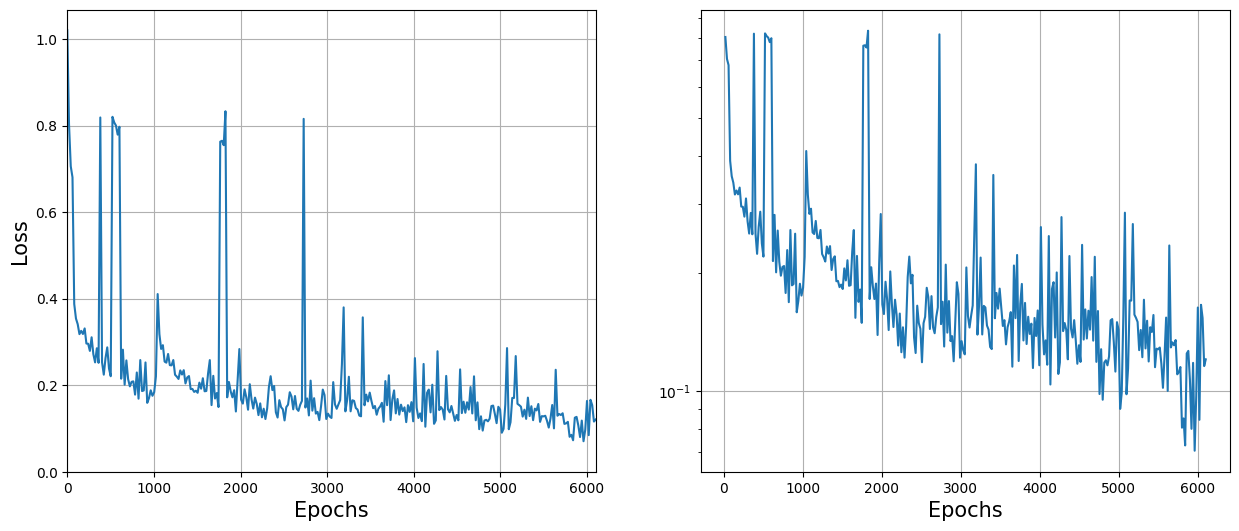

In [87]:
### Analysis  
epochs = len(loss_list)*20
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)

ax.plot(np.linspace(0, epochs, len(loss_list)), loss_list)
ax.grid()

ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlim(0, epochs)
ax.set_ylim(bottom=0)

ax2 = fig.add_subplot(1, 2, 2)

e_pts = np.linspace(0, epochs, len(loss_list))
ax2.plot(e_pts[1:], loss_list[1:])
#ax2.set_ylim()
ax2.grid()
#plt.xscale('log')~
#
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlabel('Epochs', fontsize=15)

In [88]:
t_Start_pred = 0; t_Final_pred = 30
t_eval_pred = torch.arange(t_Start_pred, t_Final_pred, dt)
node_data = odeint(model, training_data_tensor[0, 0, :, :].float(), t_eval_pred, method='rk4', options={'step_size': dt})

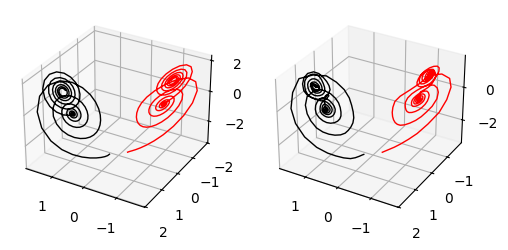

In [89]:
#Plotting results
fig = plt.figure(figsize=(6, 8))

#First Plot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot(xs=training_data_tensor[0, :, 0, 0], ys=training_data_tensor[0, :, 0, 1], zs=training_data_tensor[0, :, 0, 2], color = 'black', linewidth = 1 )
ax1.plot(xs=training_data_tensor[0, :, 1, 0], ys=training_data_tensor[0, :, 1, 1], zs=training_data_tensor[0, :, 1, 2], color = 'red', linewidth = 1 )

#ax1.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), color='red', linewidth=1)
ax1.view_init(elev = 30, azim = 120)


#Second Plot 
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot(xs=node_data[:, 0, 0].detach().numpy(), ys=node_data[:, 0, 1].detach().numpy(), zs=node_data[:, 0, 2].detach().numpy(), color = 'black', linewidth = 1 )
ax2.plot(xs=node_data[:, 1, 0].detach().numpy(), ys=node_data[:, 1, 1].detach().numpy(), zs=node_data[:, 1, 2].detach().numpy(), color = 'red', linewidth = 1 )

ax2.view_init(elev = 30, azim = 120)

plt.show()

In [67]:

def plot_interact(index):
    #Normalised Plot
    fig = plt.figure(figsize=(6, 8))
    ax1 = fig.add_subplot(1, 1, 1, projection='3d')
    #ax1.set_title('r = '+str(r_list[2*index]), fontsize=14)
    ax1.plot(xs=data_norm[0, :index, 0, 0], ys=data_norm[0, :index, 0, 1], zs=data_norm[0, :index, 0, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[0, :index, 1, 0], ys=data_norm[0, :index, 1, 1], zs=data_norm[0, :index, 1, 2], color = 'red', linewidth = 1)


    ax1.view_init(elev = 30, azim = 120)

In [68]:
def plot_interact2(index):
        #Plotting results
        fig = plt.figure(figsize=(6, 8))

        #First Plot
        ax1 = fig.add_subplot(1, 2, 1, projection='3d')
        ax1.plot(xs=training_data_tensor[0, :index, 0, 0], ys=training_data_tensor[0, :index, 0, 1], zs=training_data_tensor[0, :index, 0, 2], color = 'black', linewidth = 1 )
        ax1.plot(xs=training_data_tensor[0, :index, 1, 0], ys=training_data_tensor[0, :index, 1, 1], zs=training_data_tensor[0, :index, 1, 2], color = 'red', linewidth = 1 )

        #ax1.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), color='red', linewidth=1)
        ax1.view_init(elev = 30, azim = 120)


        #Second Plot 
        ax2 = fig.add_subplot(1, 2, 2, projection='3d')
        ax2.plot(xs=node_data[:index, 0, 0].detach().numpy(), ys=node_data[:index, 0, 1].detach().numpy(), zs=node_data[:index, 0, 2].detach().numpy(), color = 'black', linewidth = 1 )
        ax2.plot(xs=node_data[:index, 1, 0].detach().numpy(), ys=node_data[:index, 1, 1].detach().numpy(), zs=node_data[:index, 1, 2].detach().numpy(), color = 'red', linewidth = 1 )

        ax2.view_init(elev = 30, azim = 120)



In [26]:
node_data.shape

torch.Size([300, 2, 3])

In [27]:
model.break_params

Parameter containing:
tensor([7.5526], requires_grad=True)

In [90]:

interact(plot_interact2, index=IntSlider(min=0, max=500, step=1))

interactive(children=(IntSlider(value=0, description='index', max=500), Output()), _dom_classes=('widget-inter…

<function __main__.plot_interact2(index)>

## Bifurcation Diagram

In [29]:
a = 1

In [30]:
np.vectorize(lorenz.f)

In [31]:
integ.solve_ivp(fun = np.vectorize(lorenz.f), t_span = (t_Start, t_Final), y0 = y0, method = 'RK45', 
                t_eval = np.arange(t_Start, t_Final, dt), )




NameError: name 't_Start' is not defined

In [ ]:
r_eval = np.arange(0, 28, 0.1)
initial_conditions = [[1.0, 1.0, 1.0], [-1.0, -1.0, 1.0]]

t_Start = 0; t_Final = 250; t_Transient = 230; dt = 0.01

In [ ]:
x_list = []
r_list = []
for r in tqdm(r_eval):
    lorenz.rho = lambda t: r
    
    for y0 in initial_conditions:
        output = integ.solve_ivp(fun = lorenz.f, t_span = (t_Start, t_Final), y0 = y0, method = 'RK45', t_eval = np.arange(t_Start, t_Final, dt))
        z_plane = r-1
        z = output.y[2, int(t_Transient/dt):]

        #Where does do we cross the plane z = r-1 from below 
        
        indices = np.where((z[:-1] - z_plane)*(z[1:] - z_plane) <= 0)[0]
        for idx in indices:
            x_pts = output.y[0, int(t_Transient/dt):][idx]
            r_list.append(r)
            x_list.append(x_pts)
      



100%|██████████| 280/280 [02:05<00:00,  2.24it/s]
